<a href="https://colab.research.google.com/github/onenechan/BSch3v_library/blob/master/JAXAday3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# mask勉強用コード
import numpy as np
a = np.array([1.0,2,3,5,7])
mask=np.array([True,False,False,True,True]) #平均を散る対象の値
print(a[mask])
a[mask]=np.average(a[mask])
print(a)

[1. 5. 7.]
[4.33333333 2.         3.         4.33333333 4.33333333]


In [4]:
pip install healpy

     |████████████████████████████████| 18.1 MB 843 kB/s 


In [5]:
import urllib.request
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [12]:
url = 'https://data.darts.isas.jaxa.jp/pub/pds3/sln-l-tc-5-sldem2013-v1.0/lon000/data/DTM_MAP_01_N00E000S01E001SC.lbl'
norder = 10 #nside1024
nside = 2 ** norder
#cnt_pix = nside ** 2 * 12

In [7]:
def lbl2dict(lbl_url):
  import urllib.request  #URL読み出し用
  import re  #正規表現用

  dictionary = {}

  # urlの読み出し(byte型)
  com=urllib.request.urlopen(lbl_url)
  byte_data=com.read()
  com.close()

  # str型に変換
  string_data=byte_data.decode("utf-8")

  # 改行で分けてlistに代入
  a=string_data.split('\r\n')

  # 数字と小数点、正負の部分を抽出(str型)
  _UPPER_LEFT_LATITUDE = re.search(r'-?[\d\.]+', a[24])
  _UPPER_LEFT_LONGITUDE = re.search(r'-?[\d\.]+', a[25])
  _UPPER_RIGHT_LATITUDE = re.search(r'-?[\d\.]+', a[26])
  _UPPER_RIGHT_LONGITUDE = re.search(r'-?[\d\.]+', a[27])
  _LOWER_LEFT_LATITUDE =  re.search(r'-?[\d\.]+', a[28])
  _LOWER_LEFT_LONGITUDE = re.search(r'-?[\d\.]+', a[29])
  _LOWER_RIGHT_LATITUDE =  re.search(r'-?[\d\.]+', a[30])
  _LOWER_RIGHT_LONGITUDE = re.search(r'-?[\d\.]+', a[31])

  _LINE= re.search(r'-?[\d\.]+', a[75])
  _LINESAMPLE = re.search(r'-?[\d\.]+', a[76])

  # floatで保管
  dictionary["UPPER_LEFT_LATITUDE"]=float(_UPPER_LEFT_LATITUDE.group())
  dictionary["UPPER_LEFT_LONGITUDE"]=float(_UPPER_LEFT_LONGITUDE.group())
  dictionary["UPPER_RIGHT_LATITUDE"]=float(_UPPER_RIGHT_LATITUDE.group())
  dictionary["UPPER_RIGHT_LONGITUDE"]=float(_UPPER_RIGHT_LONGITUDE.group())
  dictionary["LOWER_LEFT_LATITUDE"]=float(_LOWER_LEFT_LATITUDE.group())
  dictionary["LOWER_LEFT_LONGITUDE"]=float(_LOWER_LEFT_LONGITUDE.group())
  dictionary["LOWER_RIGHT_LATITUDE"]=float(_LOWER_RIGHT_LATITUDE.group())
  dictionary["LOWER_RIGHT_LONGITUDE"]=float(_LOWER_RIGHT_LONGITUDE.group())
  dictionary["LINE"]= int(_LINE.group())
  dictionary["LINESAMPLE"]= int(_LINESAMPLE.group())

  return dictionary

In [32]:
def readdics(lbl_url,nside):
  #dictionaryから呼び出す
  import numpy as np
  import healpy as hp

  dictionary = lbl2dict(url)

  #緯度経度の羅列()
  lon2pix=np.linspace(dictionary["LOWER_LEFT_LONGITUDE"],dictionary["LOWER_RIGHT_LONGITUDE"],dictionary["LINE"])
  lat2pix=np.linspace(dictionary["UPPER_LEFT_LATITUDE"],dictionary["LOWER_LEFT_LATITUDE"],dictionary["LINE"])
  #羅列したものをgrid状にしてる
  lon2pix2,lat2pix2=np.meshgrid(lon2pix,lat2pix)
  #print(lon2pix2.shape,lat2pix2.shape)
  # ang2pixでhealpixの番号に変換

  pixnumber=hp.pixelfunc.ang2pix(nside, lon2pix2, lat2pix2, nest=True, lonlat=True)
  #print(np.unique(pixnumber).shape) #healpixの分割数 #64bit

  return pixnumber

[-717]
[-717]


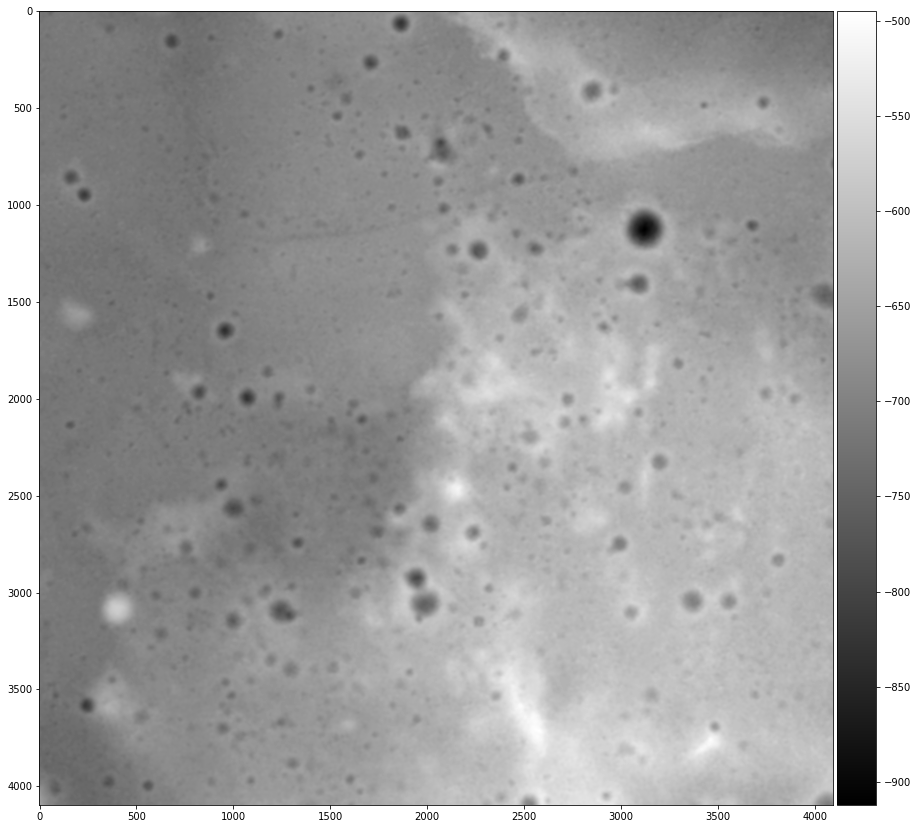

In [35]:
import re  #正規表現用
import os
import requests #データダウンロード用
import tensorflow as tf #resampling用

# urlをlbl→imgに変換
url_img = re.sub('lbl','img',url)
filename = os.path.basename(url_img)
img = urllib.request.urlretrieve(url_img, f'{filename}')

#ヘッダファイルの必要な要素を取り出す関数
dictionary = lbl2dict(url)

#リシェイプ
data = np.fromfile(filename,dtype='>i2')
data = data.reshape(dictionary["LINE"],dictionary["LINESAMPLE"])
data1 = data.copy()

#dataとpixnumberを対応させると高度の値が取れる

fig = plt.figure(figsize=(15,15))
ax = plt.gca()

pixnum = readdics(url,nside)
pixnum_unique= np.unique(readdics(url,nside))

#リサンプリング
for pix in pixnum_unique: #20番目まで
  mask = (pixnum == pix) 
  data1[mask]=np.average(data[mask])

# 中平さんコードで書き直し
 

# 一次元でやってもいいかも
# 二次元は確認用なので空全体に対応するdemをhealpixに変換できればよい
# どのhealpixがいくつあってそのの硬度を平均
# np の bincount を使うと数字が何個あるかわかる pixの数が2だったことがわかると 2で割れば良い
# binの結果の配列が最大のpix番号の配列ができてしまう
# waitを使うと一緒に入ってるpixの100 100 200

  # pix番号の二次元配列のうち ユニークを持つ場所だけをとりだす 
  # 重複しないで取り出しをする
  # print(mask)
print(data[mask])
print(data1[mask])

im = ax.imshow(data1, cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
# nsideの値に応じたheappixのサイズ感


path = os.path.join('/content/drive/My Drive/Colab Notebooks/',str(nside))
fig.savefig(path)

In [26]:
np.bincount(np.array([0, 1, 1, 3, 2, 1, 7,100]))


# 配列の長さがhealpixに含まれる画素数の最大値に依存する

array([1, 3, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [56]:
# 中平さんコード

import tensorflow as tf
nside=4096*32

pixnum = readdics(url, nside)
#pixnum_unique= np.unique( pixnum )

s=tf.sparse.bincount(np.ravel(pixnum), weights=np.ravel(data.astype(float)))
W=tf.sparse.bincount(np.ravel(pixnum))
w=tf.cast(W, tf.float64)
print(w.dtype)
print(s.dtype)
ans = s.values/w.values
print(ans)

#TODO
#sparseの型変換 DONE
#pixnumに値がある場合のみ計算する
#値が計算されたpix番号を取得する必要がある
#pixnumをweightに入れてbincountに入れてwで割ってint


#s=np.bincount(np.ravel(pixnum), weights=np.ravel(data.astype(float)), minlength=hp.nside2npix(nside) )
#w=np.bincount(np.ravel(pixnum), minlength=hp.nside2npix(nside)) #nsideに対応してpix数を数えて

<dtype: 'float64'>
<dtype: 'float64'>
tf.Tensor([-624.   -624.   -624.   ... -717.75 -717.   -717.  ], shape=(4998712,), dtype=float64)


In [68]:
import tensorflow as tf
a = tf.sparse.bincount(np.array([0, 1, 1, 3, 2, 1, 7,100]))
w = np.array([1, 2, 3, 4, 5, 6, 7, 8])
print(a.values)
np.bincount(np.array([0, 1, 1, 3, 2, 1, 7,100]))
b = tf.sparse.bincount(np.array([0, 1, 1, 3, 2, 1, 7,100]),weights=np.ravel(w.astype(float)))
print(b.values)

tf.Tensor([1 3 1 1 1 1], shape=(6,), dtype=int64)
tf.Tensor([ 1. 11.  5.  4.  7.  8.], shape=(6,), dtype=float64)
